In [714]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, minmax_scale, scale
from currency_converter import CurrencyConverter

In [715]:
CPU_CSV = './Data/cpu_raw.csv'
cpu_df = pd.read_csv(CPU_CSV)
print(cpu_df)

    Manufacturer         Name       Codename    Cores           Clock  \
0            AMD     A10-9700  Bristol Ridge        4  3.5 to 3.8 GHz   
1            AMD    A10-9700E  Bristol Ridge        4    3 to 3.5 GHz   
2            AMD     A12-9800  Bristol Ridge        4  3.8 to 4.2 GHz   
3            AMD    A12-9800E  Bristol Ridge        4  3.1 to 3.8 GHz   
4            AMD      A6-9500  Bristol Ridge        2  3.5 to 3.8 GHz   
..           ...          ...            ...      ...             ...   
402        Intel  Xeon W-3323     Ice Lake-W  12 / 24    3.5 to 4 GHz   
403        Intel  Xeon W-3335     Ice Lake-W  16 / 32    3.4 to 4 GHz   
404        Intel  Xeon W-3345     Ice Lake-W  24 / 48      3 to 4 GHz   
405        Intel  Xeon W-3365     Ice Lake-W  32 / 64    2.7 to 4 GHz   
406        Intel  Xeon W-3375     Ice Lake-W  38 / 76    2.5 to 4 GHz   

          Socket Process L3 Cache    TDP        Released  
0     Socket AM4   28 nm      NaN   65 W  Jul 27th, 2017  
1    

In [716]:
def get_boost_clock(string):
    capture = re.findall(r'\d{1}\.*\d*', string)
    if capture:
        aux = capture[-1]
        clock = float(aux)
        if "MHz" in string:
            clock /= 1000
        return clock
    else:
        return None

def get_cores_threads(string):
    capture = re.findall(r'\d+', string)
    if capture:
        if len(capture) > 1:
            return int(capture[0]), int(capture[1])
        else:
            return int(capture[0]), int(capture[0])
    else:
        return None

def get_val(string):
    capture = re.findall(r'\d+', string)
    if capture:
        return int(capture[0])
    else:
        return None

def get_year(string):
    capture = re.findall(r'\d+', string)
    if capture:
        return int(capture[1])
    else:
        return None

In [717]:
# Insert boost clock, cores and threads
clocks = [get_boost_clock(cpu_df.loc[i, 'Clock']) for i in cpu_df.index]
cores = [get_cores_threads(cpu_df.loc[i, 'Cores'])[0] for i in cpu_df.index]
threads = [get_cores_threads(cpu_df.loc[i, 'Cores'])[1] for i in cpu_df.index]
nodes = [get_val(cpu_df.loc[i, 'Process']) for i in cpu_df.index]
watts = [get_val(cpu_df.loc[i, 'TDP']) for i in cpu_df.index]
years = [get_year(cpu_df.loc[i, 'Released']) for i in cpu_df.index]
cpu_df.insert(5, "Boost", clocks)
cpu_df.insert(4, "Threads", threads)
for i in cpu_df.index:
    cpu_df.at[i, 'Cores'] = cores[i]
    cpu_df.at[i, 'Process'] = nodes[i]
    cpu_df.at[i, 'TDP'] = watts[i]

# Remove 2017
cpu_df = cpu_df[~cpu_df.Released.str.contains("2017")]
cpu_df = cpu_df[~cpu_df.Released.str.contains("2018")]

# Remove Alder Lake
cpu_df.drop(cpu_df[cpu_df["Socket"].str.contains("1700")].index, inplace=True)

# Merge Manufacturer and Name cols, remove "Socket" repetition
for i in cpu_df.index:
    manuf = cpu_df.loc[i, "Manufacturer"].split()
    old_name = cpu_df.loc[i, "Name"].split()
    new_name = " ".join(manuf + old_name)
    cpu_df.at[i, "Name"] = new_name
    socket = cpu_df.loc[i, "Socket"].split()
    cpu_df.at[i, "Socket"] = ("".join(socket)).replace("Socket", "")

cpu_df.drop(["Manufacturer"], axis=1, inplace=True)

print(cpu_df)

                  Name    Codename Cores  Threads           Clock  Boost  \
188   AMD Athlon 3000G         Zen     2        4         3.5 GHz    3.5   
189     AMD EPYC 7232P        Rome     8       16  3.1 to 3.2 GHz    3.2   
190      AMD EPYC 7252        Rome     8       16  2.8 to 3.2 GHz    3.2   
191      AMD EPYC 7262        Rome     8       16  3.1 to 3.3 GHz    3.3   
192      AMD EPYC 7272        Rome    12       24  2.6 to 3.2 GHz    3.2   
..                 ...         ...   ...      ...             ...    ...   
402  Intel Xeon W-3323  Ice Lake-W    12       24    3.5 to 4 GHz    4.0   
403  Intel Xeon W-3335  Ice Lake-W    16       32    3.4 to 4 GHz    4.0   
404  Intel Xeon W-3345  Ice Lake-W    24       48      3 to 4 GHz    4.0   
405  Intel Xeon W-3365  Ice Lake-W    32       64    2.7 to 4 GHz    4.0   
406  Intel Xeon W-3375  Ice Lake-W    38       76    2.5 to 4 GHz    4.0   

    Socket Process L3 Cache  TDP        Released  
188    AM4      14      4MB   35  No

In [718]:
# Drop server CPUs
servers = []
for i in cpu_df.index:
    name = cpu_df.loc[i, "Name"]
    if ("EPYC".lower() in name.lower()) or ("Xeon".lower() in name.lower()):
        servers.append(i)
cpu_df.drop(servers, inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

                         Name      Codename Cores  Threads           Clock  \
0            AMD Athlon 3000G           Zen     2        4         3.5 GHz   
1           AMD Ryzen 3 3200G       Picasso     4        4    3.6 to 4 GHz   
2           AMD Ryzen 5 3400G       Picasso     4        8  3.7 to 4.2 GHz   
3           AMD Ryzen 5 3500X       Matisse     6        6  3.6 to 4.1 GHz   
4            AMD Ryzen 5 3600       Matisse     6       12  3.6 to 4.2 GHz   
..                        ...           ...   ...      ...             ...   
116      Intel Core i9-11900F   Rocket Lake     8       16  2.5 to 5.2 GHz   
117      Intel Core i9-11900K   Rocket Lake     8       16  3.5 to 5.3 GHz   
118     Intel Core i9-11900KF   Rocket Lake     8       16  3.5 to 5.3 GHz   
119      Intel Core i9-11900T   Rocket Lake     8       16  1.5 to 4.9 GHz   
120  Intel Pentium Gold G6605  Comet Lake-R     2        4         4.3 GHz   

     Boost Socket Process L3 Cache  TDP        Released  
0    

In [719]:
perf = []
for i in cpu_df.index:
    perf.append(cpu_df.at[i, 'Threads'] * cpu_df.at[i, 'Boost'])

cpu_df.insert(11, "Performance", perf)
print(cpu_df)

                         Name      Codename Cores  Threads           Clock  \
0            AMD Athlon 3000G           Zen     2        4         3.5 GHz   
1           AMD Ryzen 3 3200G       Picasso     4        4    3.6 to 4 GHz   
2           AMD Ryzen 5 3400G       Picasso     4        8  3.7 to 4.2 GHz   
3           AMD Ryzen 5 3500X       Matisse     6        6  3.6 to 4.1 GHz   
4            AMD Ryzen 5 3600       Matisse     6       12  3.6 to 4.2 GHz   
..                        ...           ...   ...      ...             ...   
116      Intel Core i9-11900F   Rocket Lake     8       16  2.5 to 5.2 GHz   
117      Intel Core i9-11900K   Rocket Lake     8       16  3.5 to 5.3 GHz   
118     Intel Core i9-11900KF   Rocket Lake     8       16  3.5 to 5.3 GHz   
119      Intel Core i9-11900T   Rocket Lake     8       16  1.5 to 4.9 GHz   
120  Intel Pentium Gold G6605  Comet Lake-R     2        4         4.3 GHz   

     Boost Socket Process L3 Cache  TDP        Released  Perfor

In [720]:
# Drop irrelevant features
cpu_df.drop(['Codename', 'Cores', 'Threads', 'Clock', 'Boost', 'Process', 'L3 Cache', 'Released'], axis=1, inplace=True)

print(cpu_df)

                         Name Socket  TDP  Performance
0            AMD Athlon 3000G    AM4   35         14.0
1           AMD Ryzen 3 3200G    AM4   65         16.0
2           AMD Ryzen 5 3400G    AM4   65         33.6
3           AMD Ryzen 5 3500X    AM4   65         24.6
4            AMD Ryzen 5 3600    AM4   65         50.4
..                        ...    ...  ...          ...
116      Intel Core i9-11900F   1200   65         83.2
117      Intel Core i9-11900K   1200  125         84.8
118     Intel Core i9-11900KF   1200  125         84.8
119      Intel Core i9-11900T   1200   35         78.4
120  Intel Pentium Gold G6605   1200   65         17.2

[121 rows x 4 columns]


<AxesSubplot:>

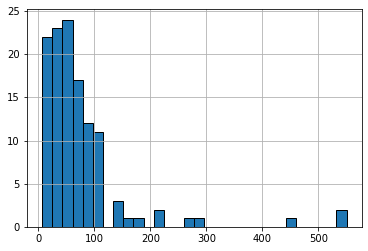

In [721]:
cpu_df['Performance'].hist(bins=30, edgecolor='k')

In [722]:
perf_labels = pd.qcut(cpu_df["Performance"], 3, labels=["light", "moderate", "high"])
for i in cpu_df.index:
    cpu_df.loc[i, "Performance"] = perf_labels[i]

# Sort values by name
cpu_df.sort_values(by=["Name"], inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

                           Name Socket TDP Performance
0              AMD Athlon 3000G    AM4  35       light
1         AMD Athlon Gold 3150G    AM4  65       light
2        AMD Athlon Gold 3150GE    AM4  35       light
3     AMD Athlon Gold PRO 3150G    AM4  65       light
4    AMD Athlon Gold PRO 3150GE    AM4  35       light
..                          ...    ...  ..         ...
116    Intel Pentium Gold G5620   1151  51       light
117    Intel Pentium Gold G6400   1200  58       light
118    Intel Pentium Gold G6500   1200  58       light
119    Intel Pentium Gold G6600   1200  58       light
120    Intel Pentium Gold G6605   1200  65       light

[121 rows x 4 columns]


In [723]:
JSON_PATH = "./Data/cpu.json"
cpu_json = pd.read_json(JSON_PATH)

cpu_json.sort_values(by=["name"], inplace=True)
cpu_json.reset_index(inplace=True, drop=True)

print(cpu_json)

                          name  rating  rating_count  price_usd  core_count  \
0                 AMD A10-9700       0             0     119.99           4   
1                 AMD A10-9700       0             0     119.99           4   
2                 AMD A10-9700       0             0     119.99           4   
3                 AMD A10-9700       0             0     119.99           4   
4                 AMD A10-9700       0             0     119.99           4   
...                        ...     ...           ...        ...         ...   
1295  Intel Pentium Gold G6400       5             2      95.00           2   
1296  Intel Pentium Gold G6400       5             2      95.00           2   
1297  Intel Pentium Gold G6400       5             2      95.00           2   
1298  Intel Pentium Gold G6400       5             2      95.00           2   
1299  Intel Pentium Gold G6400       5             2      95.00           2   

     core_clock boost_clock   tdp     integrated_gr

In [724]:
cpu_idx = []
not_in = []
for i in cpu_df.index:
    cpu_name = cpu_df.loc[i, "Name"]
    json_cpus = cpu_json["name"].tolist()
    try:
        idx = (i, json_cpus.index(cpu_name))
    except:
        idx = None
        not_in.append(i)
    if idx:
        cpu_idx.append(idx)

print(cpu_idx)

[(7, 78), (8, 91), (9, 104), (15, 182), (16, 208), (17, 221), (18, 234), (19, 247), (23, 260), (27, 325), (28, 338), (29, 351), (34, 364), (37, 377), (38, 390), (39, 403), (40, 416), (41, 429), (51, 494), (52, 520), (54, 546), (62, 559), (67, 572), (68, 585), (71, 598), (72, 611), (73, 624), (74, 637), (76, 650), (79, 663), (80, 676), (82, 832), (84, 858), (85, 871), (86, 884), (87, 897), (88, 910), (89, 923), (90, 936), (91, 949), (92, 962), (94, 1092), (95, 1105), (96, 1131), (98, 1144), (99, 1157), (100, 1170), (101, 1183), (102, 1196), (106, 1209), (110, 1222), (111, 1235), (114, 1274), (117, 1287)]


In [725]:
prices = np.zeros(len(cpu_df.index))
igpus = [None for _ in range(len(cpu_df.index))]
cpu_df.insert(4, "Price", prices)
cpu_df.insert(2, "igpu", igpus)
for i, j in cpu_idx:
    cpu_df.loc[i, "Price"] = cpu_json.loc[j, "price_usd"]
    cpu_df.loc[i, "igpu"] = cpu_json.loc[j, "integrated_graphics"]
cpu_df.drop(cpu_df.index[not_in], inplace=True)
cpu_df.dropna(subset=["Price"], inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

                        Name Socket                    igpu  TDP Performance  \
0           AMD Ryzen 3 3100    AM4                    None   65       light   
1          AMD Ryzen 3 3200G    AM4           Radeon Vega 8   65       light   
2          AMD Ryzen 3 3300X    AM4                    None   65       light   
3           AMD Ryzen 5 3600    AM4                    None   65    moderate   
4          AMD Ryzen 5 3600X    AM4                    None   95    moderate   
5         AMD Ryzen 5 3600XT    AM4                    None   95    moderate   
6          AMD Ryzen 5 5600X    AM4                    None   65    moderate   
7          AMD Ryzen 7 3700X    AM4                    None   65    moderate   
8          AMD Ryzen 7 3800X    AM4                    None  105    moderate   
9         AMD Ryzen 7 3800XT    AM4                    None  105    moderate   
10         AMD Ryzen 7 5800X    AM4                    None  105    moderate   
11         AMD Ryzen 9 3900X    AM4     

In [726]:
# Column names in lower case to adhere to Prolog convention for facts
col_names = dict(zip(cpu_df.columns, [name.lower() for name in cpu_df.columns]))
cpu_df.rename(columns=col_names, inplace=True)
print(cpu_df)

                        name socket                    igpu  tdp performance  \
0           AMD Ryzen 3 3100    AM4                    None   65       light   
1          AMD Ryzen 3 3200G    AM4           Radeon Vega 8   65       light   
2          AMD Ryzen 3 3300X    AM4                    None   65       light   
3           AMD Ryzen 5 3600    AM4                    None   65    moderate   
4          AMD Ryzen 5 3600X    AM4                    None   95    moderate   
5         AMD Ryzen 5 3600XT    AM4                    None   95    moderate   
6          AMD Ryzen 5 5600X    AM4                    None   65    moderate   
7          AMD Ryzen 7 3700X    AM4                    None   65    moderate   
8          AMD Ryzen 7 3800X    AM4                    None  105    moderate   
9         AMD Ryzen 7 3800XT    AM4                    None  105    moderate   
10         AMD Ryzen 7 5800X    AM4                    None  105    moderate   
11         AMD Ryzen 9 3900X    AM4     

In [727]:
# Convert price to EUR:
c = CurrencyConverter()
for i in cpu_df.index:
    price = cpu_df.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    cpu_df.at[i, "price"] = eur_price

cpu_df.sort_values(by=["performance", "price"], ascending=[True, False], inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

                        name socket                    igpu  tdp performance  \
0      Intel Core i9-10980XE   2066                    None  165        high   
1          AMD Ryzen 9 3950X    AM4                    None  105        high   
2          AMD Ryzen 9 5950X    AM4                    None  105        high   
3          AMD Ryzen 9 5900X    AM4                    None  105        high   
4       Intel Core i9-11900K   1200  Intel UHD Graphics 750  125        high   
5       Intel Core i9-10900K   1200  Intel UHD Graphics 630  125        high   
6      Intel Core i7-11700KF   1200                    None  125        high   
7      Intel Core i9-10900KF   1200                    None  125        high   
8          AMD Ryzen 9 3900X    AM4                    None  105        high   
9       Intel Core i9-10850K   1200  Intel UHD Graphics 630  125        high   
10      Intel Core i7-11700K   1200  Intel UHD Graphics 750  125        high   
11       Intel Core i7-11700   1200  Int

In [728]:
cpu_df.drop(index=0, inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

                        name socket                    igpu  tdp performance  \
0          AMD Ryzen 9 3950X    AM4                    None  105        high   
1          AMD Ryzen 9 5950X    AM4                    None  105        high   
2          AMD Ryzen 9 5900X    AM4                    None  105        high   
3       Intel Core i9-11900K   1200  Intel UHD Graphics 750  125        high   
4       Intel Core i9-10900K   1200  Intel UHD Graphics 630  125        high   
5      Intel Core i7-11700KF   1200                    None  125        high   
6      Intel Core i9-10900KF   1200                    None  125        high   
7          AMD Ryzen 9 3900X    AM4                    None  105        high   
8       Intel Core i9-10850K   1200  Intel UHD Graphics 630  125        high   
9       Intel Core i7-11700K   1200  Intel UHD Graphics 750  125        high   
10       Intel Core i7-11700   1200  Intel UHD Graphics 750   65        high   
11       Intel Core i9-10900   1200  Int

In [729]:
CLEAN_CPU_CSV = "./Data/cpu.csv"
cpu_df.to_csv(CLEAN_CPU_CSV, index=False)

# GPUs

In [730]:
JSON_GPU_PATH = "./Data/video-card.json"
gpu_json = pd.read_json(JSON_GPU_PATH)

print(gpu_json)

                         name  rating  rating_count  price_usd  \
0              EVGA XC GAMING       4            19     899.99   
1            Asus DUAL EVO OC       4            15     799.99   
2     NVIDIA Founders Edition       4            64        NaN   
3       EVGA XC3 BLACK GAMING       5             8        NaN   
4                Asus Phoenix       4            12     319.99   
...                       ...     ...           ...        ...   
4795     Asus STRIX GAMING OC       4            49    3299.99   
4796         MSI VENTUS 3X OC       4            21    1139.99   
4797               MSI GAMING       4           171        NaN   
4798    Zotac GAMING Twin Fan       4            10     584.82   
4799    MSI GT 1030 2GH LP OC       4             5     179.84   

                     chipset memory core_clock boost_clock           color  \
0           GeForce RTX 3060  12 GB   1320 MHz    1882 MHz           Black   
1           GeForce RTX 2060   6 GB   1365 MHz    1

In [731]:
gpu_json.sort_values(by=["chipset"], inplace=True)
gpu_json.dropna(inplace=True)
gpu_json.reset_index(inplace=True, drop=True)

print(gpu_json)

                       name  rating  rating_count  price_usd  \
0     MSI GT 1030 2GH LP OC       4             5     179.84   
1        Asus GT1030-2G-CSM       4             8      89.99   
2       Asus Phoenix Fan OC       4             3     144.88   
3     MSI GT 1030 2GH LP OC       4             5     179.84   
4        Asus GT1030-2G-CSM       4             8      89.99   
...                     ...     ...           ...        ...   
2827      MSI GAMING X TRIO       4             4    1799.99   
2828      MSI GAMING X TRIO       4             4    1799.99   
2829      MSI GAMING X TRIO       4             4    1799.99   
2830      MSI GAMING X TRIO       4             4    1799.99   
2831      MSI GAMING X TRIO       4             4    1799.99   

                chipset memory core_clock boost_clock           color  length  
0       GeForce GT 1030   2 GB   1265 MHz    1518 MHz           Black  153 mm  
1       GeForce GT 1030   2 GB   1266 MHz    1506 MHz    Black / Blue  

In [732]:
renamed_cols = {
    "price_usd": "price",
    "chipset": "model",
    "memory": "vram",
}
gpu_json.rename(columns=renamed_cols, inplace=True)
gpu_json.drop(['rating', 'rating_count', 'core_clock', 'boost_clock', 'color'], axis=1, inplace=True)
gpu_json = gpu_json[["name", "model", "vram", "length", "price"]]

print(gpu_json)

                       name              model   vram  length    price
0     MSI GT 1030 2GH LP OC    GeForce GT 1030   2 GB  153 mm   179.84
1        Asus GT1030-2G-CSM    GeForce GT 1030   2 GB  173 mm    89.99
2       Asus Phoenix Fan OC    GeForce GT 1030   2 GB  184 mm   144.88
3     MSI GT 1030 2GH LP OC    GeForce GT 1030   2 GB  153 mm   179.84
4        Asus GT1030-2G-CSM    GeForce GT 1030   2 GB  173 mm    89.99
...                     ...                ...    ...     ...      ...
2827      MSI GAMING X TRIO  Radeon RX 6800 XT  16 GB  324 mm  1799.99
2828      MSI GAMING X TRIO  Radeon RX 6800 XT  16 GB  324 mm  1799.99
2829      MSI GAMING X TRIO  Radeon RX 6800 XT  16 GB  324 mm  1799.99
2830      MSI GAMING X TRIO  Radeon RX 6800 XT  16 GB  324 mm  1799.99
2831      MSI GAMING X TRIO  Radeon RX 6800 XT  16 GB  324 mm  1799.99

[2832 rows x 5 columns]


In [733]:
gigs = [get_val(gpu_json.loc[i, 'vram']) for i in gpu_json.index]
mms = [get_val(gpu_json.loc[i, 'length']) for i in gpu_json.index]
for i in gpu_json.index:
    gpu_json.at[i, 'vram'] = gigs[i]
    gpu_json.at[i, 'length'] = mms[i]

c = CurrencyConverter()
for i in gpu_json.index:
    price = gpu_json.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    gpu_json.at[i, "price"] = eur_price

print(gpu_json)

                       name              model vram length    price
0     MSI GT 1030 2GH LP OC    GeForce GT 1030    2    153   155.38
1        Asus GT1030-2G-CSM    GeForce GT 1030    2    173    77.75
2       Asus Phoenix Fan OC    GeForce GT 1030    2    184   125.18
3     MSI GT 1030 2GH LP OC    GeForce GT 1030    2    153   155.38
4        Asus GT1030-2G-CSM    GeForce GT 1030    2    173    77.75
...                     ...                ...  ...    ...      ...
2827      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20
2828      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20
2829      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20
2830      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20
2831      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20

[2832 rows x 5 columns]


In [734]:
RAW_GPU = "./Data/gpu_raw.csv"
gpu_df = pd.read_csv(RAW_GPU)
gpu_df.sort_values(by=["Product Name"], inplace=True)
gpu_df.reset_index(inplace=True, drop=True)

print(gpu_df)

    Manufacturer            Product Name   GPU Chip        Released  \
0         NVIDIA                A10 PCIe      GA102  Apr 12th, 2021   
1         NVIDIA               A100 PCIe      GA100  Jun 22nd, 2020   
2         NVIDIA         A100 PCIe 80 GB      GA100  Jun 28th, 2021   
3         NVIDIA         A100 SXM4 40 GB      GA100  May 14th, 2020   
4         NVIDIA         A100 SXM4 80 GB      GA100  Nov 16th, 2020   
..           ...                     ...        ...             ...   
217          AMD       Xbox Series S GPU   Lockhart  Nov 10th, 2020   
218          AMD       Xbox Series X GPU   Scarlett  Nov 10th, 2020   
219        Intel                  Xe DG1        DG1  Never Released   
220        Intel              Xe DG1-SDV        DG1  Never Released   
221          AMD  Zhongshan Subor Z+ GPU  Fenghuang   Aug 3rd, 2018   

              Bus                  Memory GPU clock Memory clock  \
0    PCIe 4.0 x16   24 GB, GDDR6, 384 bit   885 MHz     1563 MHz   
1    PCIe 4

In [735]:
gpu_idx = []
not_in = []
for i in gpu_df.index:
    gpu_name = gpu_df.loc[i, "Product Name"]
    json_gpus = gpu_json["model"].tolist()
    try:
        idx = [i for i, gpu in enumerate(json_gpus) if gpu_name == gpu]
    except:
        pass
    if idx:
        gpu_idx = gpu_idx + idx
    else:
        not_in.append(i)

In [736]:
print(not_in)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 53, 54, 55, 56, 58, 59, 61, 63, 64, 67, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221]


In [737]:
gpu_df.drop(gpu_df.index[not_in], inplace=True)
gpu_df.reset_index(inplace=True, drop=True)
print(gpu_df)

   Manufacturer            Product Name    GPU Chip        Released  \
0        NVIDIA         GeForce GT 1030       GP108  May 17th, 2017   
1        NVIDIA  GeForce GTX 1650 SUPER       TU116  Nov 22nd, 2019   
2        NVIDIA        GeForce GTX 1660       TU116  Mar 14th, 2019   
3        NVIDIA  GeForce GTX 1660 SUPER       TU116  Oct 29th, 2019   
4        NVIDIA     GeForce GTX 1660 Ti       TU116  Feb 22nd, 2019   
5        NVIDIA        GeForce RTX 2060       TU106   Jan 7th, 2019   
6        NVIDIA  GeForce RTX 2070 SUPER       TU104   Jul 9th, 2019   
7        NVIDIA     GeForce RTX 2080 Ti       TU102  Sep 20th, 2018   
8        NVIDIA        GeForce RTX 3060       GA106  Jan 12th, 2021   
9        NVIDIA        GeForce RTX 3070       GA104   Sep 1st, 2020   
10       NVIDIA     GeForce RTX 3070 Ti       GA104  May 31st, 2021   
11       NVIDIA        GeForce RTX 3080       GA102   Sep 1st, 2020   
12       NVIDIA     GeForce RTX 3080 Ti       GA102  May 31st, 2021   
13    

In [738]:
tdps = [30, 100, 120, 125, 120, 160, 215, 250, 170, 220, 290, 320, 350, 350, 250, 150, 185, 230, 300]
gpu_df.insert(8, "tdp", tdps)

print(gpu_df)

   Manufacturer            Product Name    GPU Chip        Released  \
0        NVIDIA         GeForce GT 1030       GP108  May 17th, 2017   
1        NVIDIA  GeForce GTX 1650 SUPER       TU116  Nov 22nd, 2019   
2        NVIDIA        GeForce GTX 1660       TU116  Mar 14th, 2019   
3        NVIDIA  GeForce GTX 1660 SUPER       TU116  Oct 29th, 2019   
4        NVIDIA     GeForce GTX 1660 Ti       TU116  Feb 22nd, 2019   
5        NVIDIA        GeForce RTX 2060       TU106   Jan 7th, 2019   
6        NVIDIA  GeForce RTX 2070 SUPER       TU104   Jul 9th, 2019   
7        NVIDIA     GeForce RTX 2080 Ti       TU102  Sep 20th, 2018   
8        NVIDIA        GeForce RTX 3060       GA106  Jan 12th, 2021   
9        NVIDIA        GeForce RTX 3070       GA104   Sep 1st, 2020   
10       NVIDIA     GeForce RTX 3070 Ti       GA104  May 31st, 2021   
11       NVIDIA        GeForce RTX 3080       GA102   Sep 1st, 2020   
12       NVIDIA     GeForce RTX 3080 Ti       GA102  May 31st, 2021   
13    

In [739]:
gpu_json["tdp"] = 0 #Insert tdp column
for i in gpu_df.index:
    gpu_name = gpu_df.loc[i, "Product Name"]
    json_gpus = gpu_json["model"].tolist()
    try:
        idx = [i for i, gpu in enumerate(json_gpus) if gpu_name == gpu]
    except:
        pass
    if idx:
        gpu_json.loc[idx, "tdp"] = gpu_df.loc[i, "tdp"]

print(gpu_json)

                       name              model vram length    price  tdp
0     MSI GT 1030 2GH LP OC    GeForce GT 1030    2    153   155.38   30
1        Asus GT1030-2G-CSM    GeForce GT 1030    2    173    77.75   30
2       Asus Phoenix Fan OC    GeForce GT 1030    2    184   125.18   30
3     MSI GT 1030 2GH LP OC    GeForce GT 1030    2    153   155.38   30
4        Asus GT1030-2G-CSM    GeForce GT 1030    2    173    77.75   30
...                     ...                ...  ...    ...      ...  ...
2827      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20  300
2828      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20  300
2829      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20  300
2830      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20  300
2831      MSI GAMING X TRIO  Radeon RX 6800 XT   16    324  1555.20  300

[2832 rows x 6 columns]


In [740]:
gpu_json = gpu_json[["name", "model", "tdp", "vram", "length", "price"]]
gpu_json = gpu_json[gpu_json["tdp"] != 0]
gpu_json.drop(['length'], axis=1, inplace=True)
gpu_json.drop_duplicates(subset=["name"], inplace=True)
gpu_json.sort_values(by=["price"], ascending=False, inplace=True)
gpu_json.reset_index(inplace=True, drop=True)

print(gpu_json)

                              name                   model  tdp vram    price
0                  PNY VCQGV100-PB            Quadro GV100  250   32  9123.90
1          Asus ROG STRIX WHITE OC        GeForce RTX 3090  350   24  3152.76
2            Gigabyte AORUS XTREME        GeForce RTX 3090  350   24  3023.16
3                       MSI SUPRIM        GeForce RTX 3090  350   24  3022.20
4             Asus STRIX GAMING OC     GeForce RTX 2080 Ti  250   11  2851.21
5   EVGA FTW3 ULTRA GAMING LE iCX3     GeForce RTX 3080 Ti  350   12  1671.82
6           EVGA FTW3 ULTRA GAMING        GeForce RTX 3080  320   10  1649.39
7               Gigabyte GAMING OC     GeForce RTX 3070 Ti  290    8  1363.40
8          NVIDIA Founders Edition  GeForce RTX 2070 SUPER  215    8  1122.71
9            EVGA XC3 ULTRA GAMING        GeForce RTX 3070  220    8  1118.85
10               Asus KO Gaming OC        GeForce RTX 3070  220    8  1036.80
11           Gigabyte AORUS MASTER        GeForce RTX 3070  220 

In [741]:
CLEAN_GPU_CSV = "./Data/gpu.csv"
gpu_json.to_csv(CLEAN_GPU_CSV, index=False)

## Motherboards

In [742]:
JSON_MB_PATH = "./Data/motherboard.json"
mb_json = pd.read_json(JSON_MB_PATH)
mb_json.dropna(subset=["price_usd"], inplace=True)
mb_json.drop_duplicates(subset=["name"], inplace=True)
for i in mb_json.index:
    socket = mb_json.loc[i, "socket_/_cpu"].split()
    mb_json.loc[i, "socket_/_cpu"] = ("".join(socket)).replace("LGA", "")
mb_json.sort_values(by=["name"], inplace=True)
not_form = []
for i in mb_json.index:
    form = mb_json.loc[i, 'form_factor']
    if (form != "ATX") and (form != "Micro ATX"):
        print(form)
        not_form.append(i)
mb_json.drop(index=not_form, inplace=True)
mb_json.reset_index(inplace=True, drop=True)

print(mb_json)

Mini ITX
Mini ITX
Mini ITX
EATX
Mini ITX
Mini ITX
XL ATX
EATX
Mini ITX
                         name  rating  rating_count  price_usd socket_/_cpu  \
0       ASRock A320M-HDV R4.0       4             4      63.99          AM4   
1            ASRock B450 Pro4       4            38      86.00          AM4   
2    ASRock B450 Steel Legend       4            38     104.99          AM4   
3           ASRock B450M Pro4       4           123      76.98          AM4   
4   ASRock B450M Steel Legend       4            67      86.00          AM4   
..                        ...     ...           ...        ...          ...   
85   MSI MPG Z490 GAMING PLUS       4             7     189.99         1200   
86   MSI X470 GAMING PLUS MAX       4            11      99.99          AM4   
87             MSI Z390-A PRO       4            37     129.99         1151   
88             MSI Z490-A PRO       4            15     179.99         1200   
89             MSI Z590-A PRO       0             0     189.

In [743]:
renamed_cols = {
    "price_usd": "price",
    "memory_max": "max_ram",
    "socket_/_cpu": "socket"
}
mb_json.rename(columns=renamed_cols, inplace=True)
mb_json.drop(['rating', 'rating_count', 'color'], axis=1, inplace=True)
mb_json = mb_json[["name", "socket", "form_factor", "max_ram", "memory_slots", "price"]]
gigs = [get_val(mb_json.loc[i, 'max_ram']) for i in mb_json.index]
for i in mb_json.index:
    mb_json.at[i, 'max_ram'] = gigs[i]
c = CurrencyConverter()
for i in mb_json.index:
    price = mb_json.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    mb_json.at[i, "price"] = eur_price
mb_json.sort_values(by=["form_factor", "price"], ascending=[True, False], inplace=True)
mb_json.reset_index(inplace=True, drop=True)

print(mb_json)

                                    name socket form_factor max_ram  \
0        Asus ROG Crosshair VIII Formula    AM4         ATX     128   
1             Asus ROG MAXIMUS XIII HERO   1200         ATX     128   
2      Asus ROG Crosshair VIII Dark Hero    AM4         ATX     128   
3           Asus ROG STRIX Z490-E GAMING   1200         ATX     128   
4   Asus ROG Crosshair VIII Hero (WI-FI)    AM4         ATX     128   
..                                   ...    ...         ...     ...   
85                 MSI B450M PRO-VDH MAX    AM4   Micro ATX      64   
86                    Asus PRIME A320M-K    AM4   Micro ATX      32   
87                Gigabyte B450M DS3H V2    AM4   Micro ATX     128   
88                 ASRock A320M-HDV R4.0    AM4   Micro ATX      32   
89                       MSI A320M-A PRO    AM4   Micro ATX      64   

    memory_slots   price  
0              4  508.03  
1              4  415.49  
2              4  388.79  
3              4  380.15  
4           

In [744]:
CLEAN_MB_CSV = "./Data/motherboard.csv"
mb_json.to_csv(CLEAN_MB_CSV, index=False)

## PSU

In [745]:
JSON_PSU_PATH = "./Data/power-supply.json"
psu_json = pd.read_json(JSON_PSU_PATH)
psu_json.dropna(subset=["price_usd"], inplace=True)
psu_json.drop_duplicates(subset=["name"], inplace=True)
psu_json.sort_values(by=["name"], inplace=True)
psu_json.reset_index(inplace=True, drop=True)

print(psu_json)

                                         name  rating  rating_count  \
0                                ARESGAME AGV       4             7   
1                         Aerocool Integrator       4             6   
2               Antec High Current Gamer Gold       4             5   
3                            Asus ROG STRIX G       5             1   
4                              Asus ROG Strix       3             2   
5                           Asus ROG Thor 850       4            14   
6                      Cooler Master MWE Gold       4            29   
7                     Cooler Master V Gold V2       5             1   
8                    Cooler Master V SFX Gold       4             2   
9                                 Corsair AXi       5             4   
10                                 Corsair CV       4            10   
11                                Corsair CXF       5             1   
12                                Corsair CXM       4           139   
13    

In [746]:
renamed_cols = {
    "price_usd": "price",
    "efficiency_rating": "efficiency"
}
psu_json.rename(columns=renamed_cols, inplace=True)
psu_json.drop(['rating', 'rating_count', 'color', 'efficiency', 'form_factor', 'modular'], axis=1, inplace=True)
psu_json = psu_json[["name", "wattage", "price"]]
watts = [get_val(psu_json.loc[i, 'wattage']) for i in psu_json.index]
for i in psu_json.index:
    psu_json.at[i, 'wattage'] = watts[i]
c = CurrencyConverter()
for i in psu_json.index:
    price = psu_json.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    psu_json.at[i, "price"] = eur_price
psu_json.sort_values(by=["wattage", "price"], ascending=False, inplace=True)
psu_json.reset_index(inplace=True, drop=True)

print(psu_json)

                                         name wattage    price
0                                 Corsair AXi    1600   808.62
1   Thermaltake Toughpower DPS G RGB Titanium    1500  1122.34
2                         Corsair HX Platinum    1000   301.53
3               SeaSonic PRIME Ultra Titanium    1000   266.96
4                            Asus ROG STRIX G    1000   198.71
5                           Asus ROG Thor 850     850   188.35
6                              Asus ROG Strix     850   164.15
7                SeaSonic FOCUS Plus Platinum     850   141.68
8                    Cooler Master V SFX Gold     850   130.45
9                          Corsair RMx (2021)     850   129.59
10                         Corsair RMx (2018)     850   125.27
11                                     NZXT C     850   112.31
12                                 Corsair SF     750   153.90
13                   Corsair RMx White (2018)     750   125.27
14                be quiet! Straight Power 11     750  

In [747]:
CLEAN_PSU_CSV = "./Data/psu.csv"
psu_json.to_csv(CLEAN_PSU_CSV, index=False)

## Case

In [748]:
JSON_CASE_PATH = "./Data/case.json"
case_json = pd.read_json(JSON_CASE_PATH)
case_json.dropna(subset=["price_usd"], inplace=True)
case_json.drop_duplicates(subset=["name"], inplace=True)
case_json.sort_values(by=["name"], inplace=True)
case_json.reset_index(inplace=True, drop=True)

print(case_json)

                                   name  rating  rating_count  price_usd  \
0                        Aerocool Cylon       4            14      51.99   
1                Aerocool NightHawk Duo       0             0   18962.11   
2                 Asus ROG Strix Helios       4             9     279.99   
3   Cooler Master MasterBox MB311L ARGB       4            37      74.98   
4   Cooler Master MasterBox MB320L ARGB       4            13      74.98   
..                                  ...     ...           ...        ...   
67                      Rosewill FBM-X1       3            28      29.99   
68                Thermaltake Core W200       0             0     549.99   
69        Thermaltake S100 Snow Edition       4             9     298.50   
70                Thermaltake Versa H18       4            39      36.74   
71            be quiet! Pure Base 500DX       4            50     109.99   

                   type          color  power_supply side_panel_window  \
0         ATX

In [749]:
for i in case_json.index:
    ftype = case_json.at[i, 'type']
    ftype = ftype.split()
    try:
        atx = ftype[0].index('ATX')
        new_type = ftype[0][:atx] + " " + ftype[0][atx:]
    except:
        new_type = ftype[0]
    case_json.at[i, 'type'] = new_type.lstrip()

renamed_cols = {
    "type": "form_factor",
    "price_usd": "price"
}
case_json.rename(columns=renamed_cols, inplace=True)
case_json.drop(['rating', 'rating_count', 'color', 'power_supply', 'side_panel_window'], axis=1, inplace=True)
case_json = case_json[["name", "form_factor", "price"]]
case_json.drop(index=1, inplace=True)
not_form = []
for i in case_json.index:
    form = case_json.loc[i, 'form_factor']
    if (form != "ATX") and (form != "Micro ATX"):
        print(form)
        not_form.append(i)
case_json.drop(index=not_form, inplace=True)
case_json.sort_values(by=["form_factor","price"], ascending=[True, False], inplace=True)
case_json.reset_index(inplace=True, drop=True)

print(case_json)

Mini
Mini
Mini
                             name form_factor   price
0           Thermaltake Core W200         ATX  549.99
1                   Corsair 1000D         ATX  514.99
2           Asus ROG Strix Helios         ATX  279.99
3        Corsair Crystal 680X RGB         ATX  264.99
4    Corsair Obsidian 500D RGB SE         ATX  264.99
..                            ...         ...     ...
63  Cooler Master MasterBox Q300L   Micro ATX   46.86
64            Deepcool MATREXX 30   Micro ATX   39.99
65          Thermaltake Versa H18   Micro ATX   36.74
66                Rosewill FBM-X1   Micro ATX   29.99
67                Rosewill FBM-01   Micro ATX   25.99

[68 rows x 3 columns]


In [750]:
CLEAN_CASE_CSV = "./Data/case.csv"
case_json.to_csv(CLEAN_CASE_CSV, index=False)

## Cooler

                                     name                   socket  \
0                         GIGABYTE ATC800  [AM4, 1151, 1200, 2066]   
1                            Dark Rock TF  [AM4, 1151, 1200, 2066]   
2                            CORSAIR A500  [AM4, 1151, 1200, 2066]   
3             Noctua NH-D15 chromax.black  [AM4, 1151, 1200, 2066]   
4                          Noctua NH-U12A  [AM4, 1151, 1200, 2066]   
5                           Noctua NH-D15  [AM4, 1151, 1200, 2066]   
6                         Dark Rock Pro 4  [AM4, 1151, 1200, 2066]   
7                    Noctua NH-D15 SE-AM4                    [AM4]   
8                         GIGABYTE ATC700  [AM4, 1151, 1200, 2066]   
9                         GIGABYTE XTC700             [1151, 1200]   
10                         Noctua NH-D15S  [AM4, 1151, 1200, 2066]   
11                            Dark Rock 4  [AM4, 1151, 1200, 2066]   
12                         Noctua NH-C14S  [AM4, 1151, 1200, 2066]   
13                  

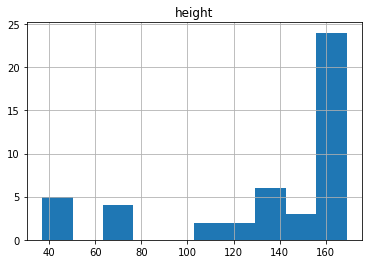

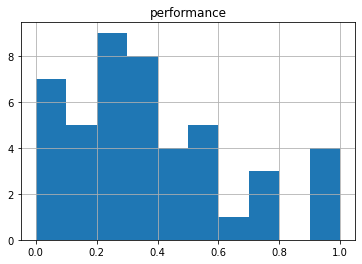

In [751]:
## Process copied text from https://thegamingstuff.com/database/cpu-air-cooler-database/

with open("./Data/air_coolers.txt", "r") as f:
	contents = f.read()
	f.close()
contents = contents.split()
contents = [elem for i, elem in enumerate(contents) if i not in range(26)]
contents = " ".join(contents)
contents = contents.split("Amazon")
aux_list = []
for i, content in enumerate(contents):
    if "TBA" in content:
        contents.pop(i)
        aux = content.split("TBA")
        aux_list = aux_list + aux
contents = contents + aux_list

pos_sockets = ['AM4', 'TR4', ['1151', '1200'], '2066']
c_dict = {
    'name': [], 
    'height': [], 
    'width': [],
    'depth': [],
    'socket': [],
    'price':[]
    }
for element in contents:
    sockets = re.findall(r"[YNoes]{2,3}(?!\w)", element)
    this_socket = []
    for yn, socket in zip(sockets[1:], pos_sockets):
        if yn == "Yes":
            if isinstance(socket, list):
                this_socket += socket
            else:
                this_socket += [socket]
    if (len(this_socket) == 1) and ("TR4" in this_socket):
        continue
    c_dict['socket'].append(this_socket)

    dims = re.findall(r"\d+\.*\d*[m]{2}", element)
    dims = [float(dim.replace("mm", "")) for dim in dims]
    try:
        h, w, d = dims
    except:
        print(dims, element)
    c_dict['height'].append(h)
    c_dict['width'].append(w)
    c_dict['depth'].append(d)

    try:
        c_dict['name'].append(re.findall(r"(?:\ )*([A-Za-z\-\d\.\ ]+) (?:\d+\.*\d*[m]{2}) (?:\d+\.*\d*[m]{2}) (?:\d+\.*\d*[m]{2})", element)[0])
    except:
        print(element)

    c_dict['price'].append(float(re.findall(r"\${1}\d+\.*\d*", element)[0].replace("$", "")))

cool_df = pd.DataFrame(c_dict)
c = CurrencyConverter()
for i in cool_df.index:
    price = cool_df.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    cool_df.at[i, "price"] = eur_price


cool_df.sort_values(by=["name"], inplace=True)
cool_df.dropna(inplace=True)
cool_df.reset_index(inplace=True, drop=True)

cool_df.hist(column="height")
cooling = []
for i in cool_df.index:
    cooling.append(cool_df.loc[i, 'height'] * cool_df.loc[i, 'width'] * cool_df.loc[i, 'depth'])

cooling = (cooling - min(cooling)) / (max(cooling) - min(cooling))
cool_df.insert(5, "performance", cooling)


cool_df.hist(column="performance")
perf_labels = pd.qcut(cool_df["performance"], 3, labels=["light", "moderate", "high"])
for i in cool_df.index:
    cool_df.loc[i, "performance"] = perf_labels[i]

cool_df.drop(['height', 'width', 'depth'], axis=1, inplace=True)
cool_df.sort_values(by=["performance","price"], ascending=[True, False], inplace=True)
cool_df.reset_index(inplace=True, drop=True)

print(cool_df)

CLEAN_COOL_CSV = "./Data/cooler.csv"
cool_df.to_csv(CLEAN_COOL_CSV, index=False)

## RAM

In [752]:
JSON_RAM_PATH = "./Data/ram.json"
ram_json = pd.read_json(JSON_RAM_PATH)
ram_json.dropna(subset=["price_usd"], inplace=True)
ram_json.dropna(subset=["modules"], inplace=True)
ram_json.drop_duplicates(subset=["name"], inplace=True)
ram_json.sort_values(by=["name"], inplace=True)
ram_json.reset_index(inplace=True, drop=True)

print(ram_json)

                                      name  rating  rating_count  price_usd  \
0            ADATA XPG SPECTRIX D60G 16 GB       5            16      92.99   
1     Corsair Dominator Platinum RGB 32 GB       4             5     339.99   
2                  Corsair Vengeance 16 GB       4            91      86.99   
3             Corsair Vengeance LPX 128 GB       0             0    3832.00   
4              Corsair Vengeance LPX 16 GB       4           338      88.99   
5              Corsair Vengeance LPX 32 GB       4            23     189.99   
6               Corsair Vengeance LPX 8 GB       4            10      55.99   
7          Corsair Vengeance RGB Pro 16 GB       4           287     103.99   
8          Corsair Vengeance RGB Pro 32 GB       4            28     212.24   
9          Corsair Vengeance RGB Pro 64 GB       5             2     400.00   
10      Corsair Vengeance RGB Pro SL 16 GB       5             2     104.99   
11      Corsair Vengeance RGB Pro SL 32 GB       0  

In [753]:
def get_ram(string):
    return (int(x) for x in re.findall(r"(\d+) x (\d+)GB", string)[0])

In [754]:
modules = []
memory_per_module = []
for i in ram_json.index:
    m, mpm = get_ram(ram_json.loc[i, "modules"])
    modules.append(m)
    memory_per_module.append(mpm)

renamed_cols = {
    "price_usd": "price"
}
ram_json.rename(columns=renamed_cols, inplace=True)
ram_json.drop(['rating', 'rating_count', 'modules', 'color', 'price_/_gb', 'cas_latency', 'first_word_latency'], axis=1, inplace=True)
ram_json.insert(3, "modules", modules)
ram_json.insert(4, "memory_per_module", memory_per_module)
ram_json = ram_json[["name", "modules", "memory_per_module", "price"]]
ram_json.reset_index(inplace=True, drop=True)

c = CurrencyConverter()
for i in ram_json.index:
    price = ram_json.loc[i, "price"]
    eur_price = np.round(c.convert(price, "USD", "EUR"), 2)
    ram_json.at[i, "price"] = eur_price

ram_json.sort_values(by=["memory_per_module", "price"], ascending=False, inplace=True)
ram_json.reset_index(inplace=True, drop=True)

print(ram_json)

                                      name  modules  memory_per_module  \
0              Crucial CT64G4LFQ424A 64 GB        1                 64   
1           G.Skill Trident Z Royal 256 GB        8                 32   
2           G.Skill Trident Z Royal 128 GB        4                 32   
3             G.Skill Trident Z RGB 128 GB        4                 32   
4          Corsair Vengeance RGB Pro 64 GB        2                 32   
5                  Crucial Ballistix 64 GB        2                 32   
6              G.Skill Trident Z RGB 64 GB        2                 32   
7                  G.Skill Ripjaws V 64 GB        2                 32   
8             Corsair Vengeance LPX 128 GB        8                 16   
9              G.Skill Trident Z Neo 32 GB        2                 16   
10             G.Skill Trident Z RGB 32 GB        2                 16   
11         Corsair Vengeance RGB Pro 32 GB        2                 16   
12             Crucial Ballistix RGB 3

In [755]:
ram_json.drop(index=0, inplace=True)
ram_json.reset_index(inplace=True, drop=True)

print(ram_json)

                                      name  modules  memory_per_module  \
0           G.Skill Trident Z Royal 256 GB        8                 32   
1           G.Skill Trident Z Royal 128 GB        4                 32   
2             G.Skill Trident Z RGB 128 GB        4                 32   
3          Corsair Vengeance RGB Pro 64 GB        2                 32   
4                  Crucial Ballistix 64 GB        2                 32   
5              G.Skill Trident Z RGB 64 GB        2                 32   
6                  G.Skill Ripjaws V 64 GB        2                 32   
7             Corsair Vengeance LPX 128 GB        8                 16   
8              G.Skill Trident Z Neo 32 GB        2                 16   
9              G.Skill Trident Z RGB 32 GB        2                 16   
10         Corsair Vengeance RGB Pro 32 GB        2                 16   
11             Crucial Ballistix RGB 32 GB        2                 16   
12           G.Skill Trident Z Royal 3

In [756]:
ram_json.drop(index=0, inplace=True)
ram_json.reset_index(inplace=True, drop=True)

print(ram_json)

                                      name  modules  memory_per_module  \
0           G.Skill Trident Z Royal 128 GB        4                 32   
1             G.Skill Trident Z RGB 128 GB        4                 32   
2          Corsair Vengeance RGB Pro 64 GB        2                 32   
3                  Crucial Ballistix 64 GB        2                 32   
4              G.Skill Trident Z RGB 64 GB        2                 32   
5                  G.Skill Ripjaws V 64 GB        2                 32   
6             Corsair Vengeance LPX 128 GB        8                 16   
7              G.Skill Trident Z Neo 32 GB        2                 16   
8              G.Skill Trident Z RGB 32 GB        2                 16   
9          Corsair Vengeance RGB Pro 32 GB        2                 16   
10             Crucial Ballistix RGB 32 GB        2                 16   
11           G.Skill Trident Z Royal 32 GB        2                 16   
12      Corsair Vengeance RGB Pro SL 3

In [757]:
CLEAN_RAM_CSV = "./Data/ram.csv"
ram_json.to_csv(CLEAN_RAM_CSV, index=False)

# Create the .pl database

In [758]:
CLEAN_CPU_CSV = "./Data/cpu.csv"
cpu_df = pd.read_csv(CLEAN_CPU_CSV)

CLEAN_GPU_CSV = "./Data/gpu.csv"
gpu_df = pd.read_csv(CLEAN_GPU_CSV)

CLEAN_MB_CSV = "./Data/motherboard.csv"
mb_df = pd.read_csv(CLEAN_MB_CSV)

CLEAN_PSU_CSV = "./Data/psu.csv"
psu_df = pd.read_csv(CLEAN_PSU_CSV)

CLEAN_COOL_CSV = "./Data/cooler.csv"
cool_df = pd.read_csv(CLEAN_COOL_CSV)

CLEAN_CASE_CSV = "./Data/case.csv"
case_df = pd.read_csv(CLEAN_CASE_CSV)

CLEAN_RAM_CSV = "./Data/ram.csv"
ram_df = pd.read_csv(CLEAN_RAM_CSV)

def write_df(part, df, f):
    for i in df.index:
        fact_names = df.columns
        fact_data = df.iloc[i].values
        fact_str = "{}(".format(part)
        for i, fact in enumerate(zip(fact_names, fact_data)):
            if i != 0:
                name, data = fact
                if isinstance(data, str) and not(data.startswith("[")):
                    fact_str = fact_str + ", {}(\'{}\')".format(name, data)
                else:
                    fact_str = fact_str + ", {}({})".format(name, data)
            else:
                _, data = fact
                fact_str = fact_str + "\'{}\'".format(data)
        fact_str = fact_str + ").\n"
        f.write(fact_str)

with open("database.pl", "w") as f:
    write_df("cpu", cpu_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("gpu", gpu_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("board", mb_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("psu", psu_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("cooler", cool_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("case", case_df, f)
    f.close()

with open("database.pl", "a") as f:
    f.write("\n")
    write_df("ram", ram_df, f)
    f.close()